In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from statsmodels.api import OLS, add_constant

In [2]:
### '01-06 SOUID: Source identifier\n',
  # '08-15 DATE : Date YYYYMMDD\n',
  # '17-21 TG   : mean temperature in 0.1 &#176;C\n',
  # "23-27 Q_TG : Quality code for TG (0='valid'; 1='suspect'; 9='missing')\n",

In [3]:
pwd

'/Users/monikaju/Desktop/Spiced_classes/logistic-lemongrass-encounter-notes/week_05'

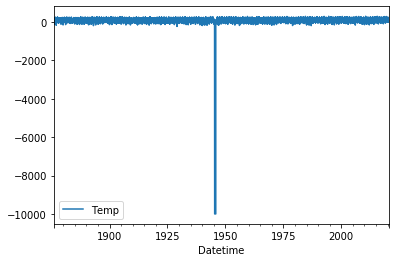

In [4]:
#Importing the data Frame
df = pd.read_csv('/Users/monikaju/Desktop/Data/ECA_blended_custom/TG_STAID002759.txt')

# Rename the columns (remove the spaces from the columns)
df = df.rename(columns={" SOUID": "Identifier", "    DATE": "Date","   TG": "Temp", " Q_TG": "Quality"})

# Transform Datetime to 'datetime'
df[('Datetime')]=pd.to_datetime(df['Date'], format='%Y%m%d')

# Drop a column
df.drop(['Date'], axis = 1 )

# Plot a graph
df.plot(y=['Temp'], x='Datetime')

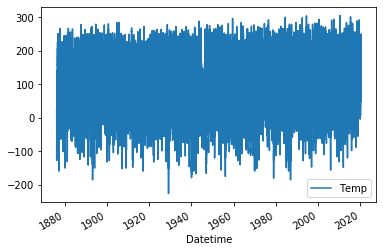

In [5]:
## Based on the graph there are some outliers that could represent a problem for our model 
# Drop the outliers
df = df.loc[df['Temp'] > -800]
df.plot(y=['Temp'], x='Datetime')

In [6]:
# Extract month, year and day from ('DATE_TIME')
df['Month'] = pd.to_datetime(df['Datetime']).dt.month
df['Year'] = pd.to_datetime(df['Datetime']).dt.year
df['Day'] = pd.to_datetime(df['Datetime']).dt.day
df['Year_month']=df.Year.astype(str) + " " + df.Month.astype(str)
df['Month_day']=df.Month.astype(str) + " " + df.Day.astype(str)

# Set the Datetime as an Index
df.set_index('Datetime', inplace=True)

/Users/monikaju/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/monikaju/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/monikaju/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

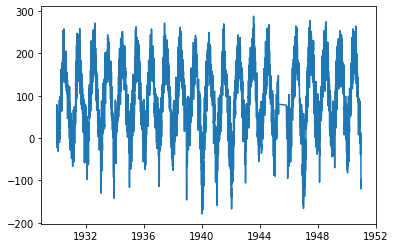

In [7]:
df2 = df['1930':'1950'] 
plt.plot(df2['Temp'])

In [8]:
df = df[df['Year'] > 1946]

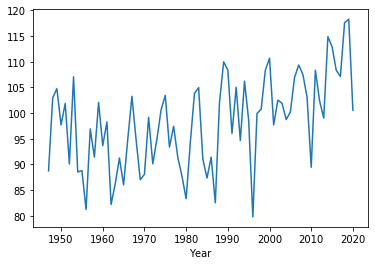

In [9]:
df.groupby(['Year'])['Temp'].mean().plot()

In [10]:
# converting temp into Kelvin 
df['Temp_Kelvin']= (df['Temp']*0.1)+273
df.drop(['Date'], axis = 1 )

/Users/monikaju/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Identifier,Temp,Quality,Month,Year,Day,Year_month,Month_day,Temp_Kelvin
Datetime,,,,,,,,,
1947-01-01,128124,-24,0,1,1947,1,1947 1,1 1,270.6
1947-01-02,128124,-35,0,1,1947,2,1947 1,1 2,269.5
1947-01-03,128124,-45,0,1,1947,3,1947 1,1 3,268.5
1947-01-04,128124,-127,0,1,1947,4,1947 1,1 4,260.3
1947-01-05,128124,-150,0,1,1947,5,1947 1,1 5,258.0
...,...,...,...,...,...,...,...,...,...
2020-06-26,111448,226,0,6,2020,26,2020 6,6 26,295.6
2020-06-27,111448,250,0,6,2020,27,2020 6,6 27,298.0
2020-06-28,111448,224,0,6,2020,28,2020 6,6 28,295.4


## Spliting the data / Featuring Engineering

In [11]:
# Creating the Y_test and Y_train

test= df['2019-06-30':'2020-06-30']
train= df[:'2019-06-30']

In [69]:
#Size of the training and test Set
test.shape,train.shape

((367, 10), (26479, 10))

In [13]:
#Creating a function that does all the possible(relevant) featuring engineering
def feature_engineering(data):
    data= data.copy()
    data['Temp_diff']=data['Temp'].diff()
    data['second_order_difference'] = data['Temp_diff'].diff()
    data['percentage_change'] = data['Temp_Kelvin'].pct_change()
    data['Monthly_means'] = data.groupby('Month_day')['percentage_change'].transform('mean')
    data['deseasonalized'] = data['percentage_change'] - data['Monthly_means']
    data['Temp_Kelvin(-1)']=data['Temp_Kelvin'].shift(1)
    data['Temp_Kelvin(-2)']=data['Temp_Kelvin'].shift(2)
    data['Temp_Kelvin(-3)']=data['Temp_Kelvin'].shift(3)
    data['Temp_Kelvin_percentage_change']= (data['Temp_Kelvin(-1)']*data['percentage_change'])+(data['Temp_Kelvin(-1)'])
    data['Temp_Kelvin_Monthlymean']= (data['Temp_Kelvin(-1)']*data['Monthly_means'])+(data['Temp_Kelvin(-1)'])
    data['Temp_Kelvin_deseasonlized']= (data['Temp_Kelvin(-1)']*data['deseasonalized'])+(data['Temp_Kelvin(-1)'])
    data = data.dropna()
    return data

In [14]:
#Creating the Y_train
y_train = feature_engineering(train)
y_train.head()

,Identifier,Date,Temp,Quality,Month,Year,Day,Year_month,Month_day,Temp_Kelvin,...,second_order_difference,percentage_change,Monthly_means,deseasonalized,Temp_Kelvin(-1),Temp_Kelvin(-2),Temp_Kelvin(-3),Temp_Kelvin_percentage_change,Temp_Kelvin_Monthlymean,Temp_Kelvin_deseasonlized
Datetime,,,,,,,,,,,,,,,,,,,,,
1947-01-04,128124,19470104,-127,0,1,1947,4,1947 1,1 4,260.3,...,-72.0,-0.030540,-0.001516,-0.029024,268.5,269.5,270.6,260.3,268.092873,260.707127
1947-01-05,128124,19470105,-150,0,1,1947,5,1947 1,1 5,258.0,...,59.0,-0.008836,0.000131,-0.008967,260.3,268.5,269.5,258.0,260.334185,257.965815
1947-01-06,128124,19470106,-158,0,1,1947,6,1947 1,1 6,257.2,...,15.0,-0.003101,-0.001230,-0.001871,258.0,260.3,268.5,257.2,257.682624,257.517376
1947-01-07,128124,19470107,-123,0,1,1947,7,1947 1,1 7,260.7,...,43.0,0.013608,0.000486,0.013122,257.2,258.0,260.3,260.7,257.325126,260.574874
1947-01-08,128124,19470108,-138,0,1,1947,8,1947 1,1 8,259.2,...,-50.0,-0.005754,0.001543,-0.007297,260.7,257.2,258.0,259.2,261.102318,258.797682


In [15]:
#Creating the Y_test
y_test = feature_engineering(test)
y_test.shape

(364, 21)

In [70]:
# Function that plot some variables after featuring engineering
def plot_forecast(y_train, y_test, columns):
 
    y_train.Temp_Kelvin.plot(label='Training Data')
    y_test.Temp_Kelvin.plot(label=('Test Data'),color='red')
    for column in columns:
        y_test[column].plot(label=column,color='green')
    plt.ylabel('Temp', fontsize=12)
    plt.xlabel('Date', fontsize=12)
    plt.legend()
    plt.show()

In [71]:
y_train_short = y_train['2016':'2019']

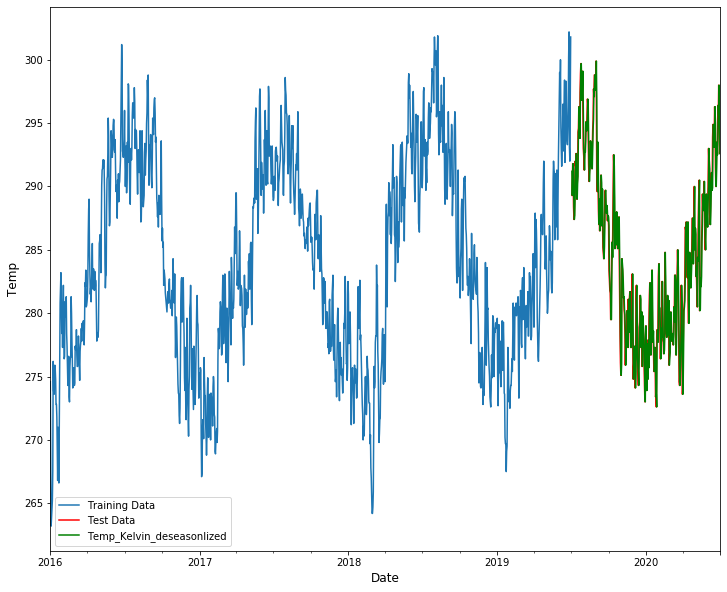

In [72]:
plt.figure(figsize=(12, 10))
plot_forecast(y_train_short, y_test,['Temp_Kelvin_deseasonlized'])

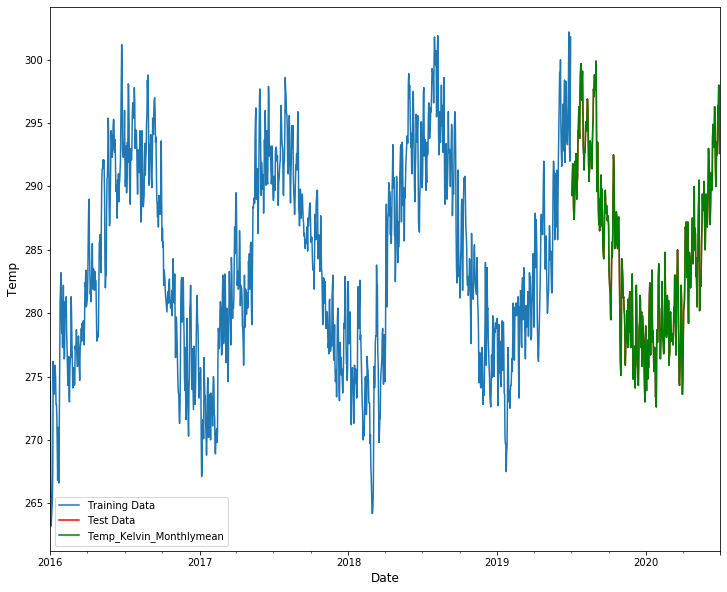

In [73]:
plt.figure(figsize=(12, 10))
plot_forecast(y_train_short, y_test,['Temp_Kelvin_Monthlymean'])

## Running a simple base model 

In [20]:
# Defining the Y of my model
y_train2 =y_train[['Temp_Kelvin']]

In [21]:
y_train2.head(3)

,Temp_Kelvin
Datetime,
1947-01-04,260.3
1947-01-05,258.0
1947-01-06,257.2


In [22]:
y_train['timestep']= np.arange(1, len(y_train2)+1)

In [23]:
# Defining the X of my model as an array
X_train = add_constant(y_train['timestep'])

In [24]:
m1 = OLS(y_train2, X_train) # OLS stands for ordinary least squares and it is a method
# to solve a linear regression
results = m1.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Temp_Kelvin   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     82.95
Date:                Fri, 14 Aug 2020   Prob (F-statistic):           8.97e-20
Time:                        15:12:56   Log-Likelihood:                -92359.
No. Observations:               26476   AIC:                         1.847e+05
Df Residuals:                   26474   BIC:                         1.847e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        282.0328      0.097   2896.762      0.000     281.842     282.224
timestep    5.801e-05   6.37e-06      9.108      0.000    4.55e-05    7.05e-05
==============================================================================
Omnibus:                     1010.253   Durbin-Watson:                   0.091
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              503.606
Skew:                          -0.140   Prob(JB):                    4.40e-110
Kurtosis:                       2.385   Cond. No.                     3.06e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.06e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Linear autoregression model

X- past temperature
Y- Future temperature
𝑦𝑡=𝑎1𝑦𝑡−1+𝑎2𝑡−2+...+𝑏+𝜖

In [25]:
X= y_train[['Temp_Kelvin(-1)', 'Temp_Kelvin(-2)','Temp_Kelvin(-3)']]
Y= y_train['Temp_Kelvin']

In [26]:
## Fitting the model
m = LinearRegression()
m.fit(X, Y)
m.score(X, Y)

0.913967111495575

In [27]:
Y_predict = m.predict(X)

In [28]:
y_train.shape

(26476, 22)

In [29]:
Y_predict.shape

(26476,)

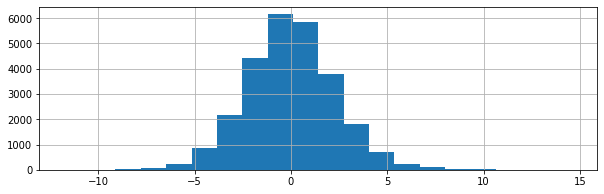

In [30]:
(Y_predict - Y).hist(bins=20, figsize=(10,3))

In [36]:
#Running the model for the test data
X_test= y_test[['Temp_Kelvin(-1)', 'Temp_Kelvin(-2)','Temp_Kelvin(-3)']]
Y_test= y_test['Temp_Kelvin']

In [37]:
Y_predict_test = m.predict(X_test)
m.score(X_test, Y_test)

0.8958532598926989

## Train a  profet model

In [38]:
from fbprophet import Prophet

Importing plotly failed. Interactive plots will not work.


In [39]:
m2 = Prophet(weekly_seasonality=True, daily_seasonality=True)

In [40]:
# Obtain the proper Data Frame to run the model
df2 = y_train[['Date', 'Temp_Kelvin']]
df2= df2.drop(['Date'], axis = 1 )
df2.reset_index(level=0, inplace=True)
df2 = df2.rename(columns={'Datetime':'ds', 'Temp_Kelvin':'y'})

In [41]:
df2

,ds,y
0,1947-01-04,260.3
1,1947-01-05,258.0
2,1947-01-06,257.2
3,1947-01-07,260.7
4,1947-01-08,259.2
...,...,...
26471,2019-06-26,302.2
26472,2019-06-27,293.1
26473,2019-06-28,292.0
26474,2019-06-29,296.5


In [42]:
m2.fit(df2)

In [43]:
## Create the years into the future
future = m2.make_future_dataframe(periods=240, freq='MS', include_history=False)
#20 years into the future

In [44]:
future.shape

(240, 1)

In [45]:
Forecast= m2.predict(future)

In [46]:
Forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2019-07-01,267.057556,288.230358,297.804275,267.057556,267.057556,26.084866,26.084866,26.084866,17.256615,...,0.075616,0.075616,0.075616,8.752636,8.752636,8.752636,0.0,0.0,0.0,293.142422
1,2019-08-01,267.065050,289.423861,299.235822,267.065050,267.065050,27.374874,27.374874,27.374874,17.256615,...,-0.011451,-0.011451,-0.011451,10.129710,10.129710,10.129710,0.0,0.0,0.0,294.439924
2,2019-09-01,267.072544,286.915464,296.474601,267.072544,267.072544,24.546296,24.546296,24.546296,17.256615,...,0.008153,0.008153,0.008153,7.281528,7.281528,7.281528,0.0,0.0,0.0,291.618840
3,2019-10-01,267.079797,282.320070,291.901504,267.079797,267.079797,20.069672,20.069672,20.069672,17.256615,...,0.025506,0.025506,0.025506,2.787552,2.787552,2.787552,0.0,0.0,0.0,287.149469
4,2019-11-01,267.087291,277.257228,286.703924,267.087291,267.087291,14.796075,14.796075,14.796075,17.256615,...,-0.023284,-0.023284,-0.023284,-2.437256,-2.437256,-2.437256,0.0,0.0,0.0,281.883366


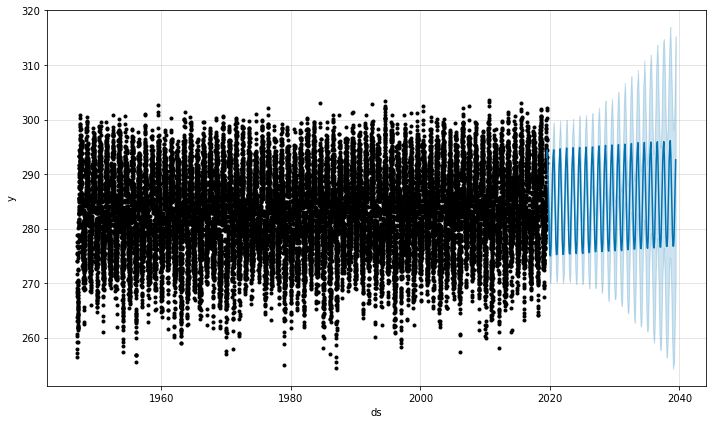

In [47]:
fig = m2.plot(Forecast)

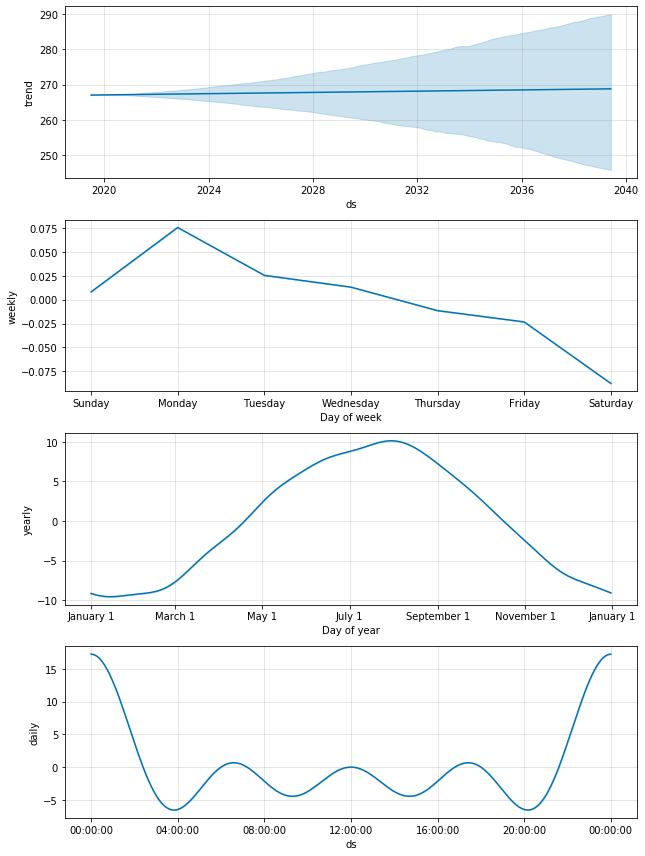

In [48]:
fig2 = m2.plot_components(Forecast)